# Immigration Data Warehouse
## Data Engineering Capstone Project
### 1 Investigate Data and Scope the Project
This notebook investigates the structure and quality of the datasets potentially involved with the immigration data warehouse:

1. Immigration Data
1. Countries
1. Cities & Demography
1. Airport Codes
1. Land Temperatures

Based on this investigation, a DWH data model will be suggested and the ETL process designed.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType, DateType
import pyspark.sql.functions as f
import helper as h

In [2]:
spark = SparkSession.builder \
        .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:2.7.5') \
        .getOrCreate()

### 1.1 I94 Immigration Data

This data comes from the [US National Tourism and Trade Office](https://travel.trade.gov/research/reports/i94/historical/2016.html). A data dictionary is included in the workspace.

In [3]:
i94data = spark.read.parquet('i94_data')

In [4]:
i94data = i94data \
    .withColumnRenamed('cicid',    'i94_id') \
    .withColumnRenamed('arrdate',  'arrive_date') \
    .withColumnRenamed('i94yr',    'arrive_year') \
    .withColumnRenamed('i94mon',   'arrive_month') \
    .withColumnRenamed('i94port',  'arrive_port') \
    .withColumnRenamed('i94mode',  'arrive_by') \
    .withColumnRenamed('airline',  'arrive_airline') \
    .withColumnRenamed('fltno',    'arrive_flight') \
    .withColumnRenamed('entdepa',  'arrive_flag') \
    .withColumnRenamed('i94addr',  'arrive_to_state') \
    .withColumnRenamed('i94cit',   'pers_country_birth') \
    .withColumnRenamed('i94res',   'pers_country_resid') \
    .withColumnRenamed('biryear',  'pers_birth_year') \
    .withColumnRenamed('i94bir',   'pers_age') \
    .withColumnRenamed('occup',    'pers_occupation') \
    .withColumnRenamed('gender',   'pers_gender') \
    .withColumnRenamed('insnum',   'pers_ins_number')  \
    .withColumnRenamed('i94visa',  'visa') \
    .withColumnRenamed('visapost', 'visa_issued') \
    .withColumnRenamed('visatype', 'visa_type') \
    .withColumnRenamed('dtaddto',  'allow_stay_until') \
    .withColumnRenamed('entdepd',  'depart_flag') \
    .withColumnRenamed('depdate',  'depart_date') \
    .withColumnRenamed('count',    'cnt') \
    .withColumnRenamed('dtadfile', 'char_date') \
    .withColumnRenamed('entdepu',  'update_flag') \
    .withColumnRenamed('matflag',  'match_flag') \
    .withColumnRenamed('admnum',   'admission_number')

#### 1.1.1 Drop columns
Columns with small percentage of present values can be dropped

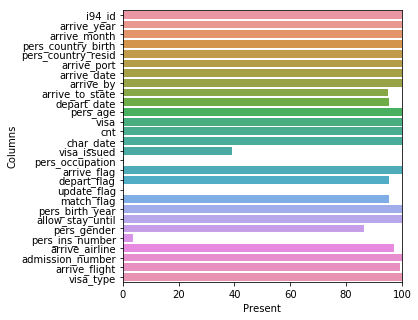

In [5]:
h.plot_present(i94data)

Column `cnt` can be dropped because it's constant:

In [6]:
i94data.groupBy('cnt').count().sort(f.desc('count')).show(10)

+---+-------+
|cnt|  count|
+---+-------+
|1.0|3096313|
+---+-------+



In [7]:
i94data = i94data.drop('cnt', 'pers_ins_number', 'pers_occupation', 'update_flag', 'char_date')

#### 1.1.2 Type conversions
float to int, dates to datetime

In [8]:
i94data = i94data \
    .withColumn('i94_id',             i94data.i94_id.cast(IntegerType())) \
    .withColumn('arrive_date',        h.udf_date(i94data.arrive_date)) \
    .withColumn('arrive_month',       i94data.arrive_month.cast(IntegerType())) \
    .withColumn('arrive_year',        i94data.arrive_year.cast(IntegerType())) \
    .withColumn('pers_age',           i94data.pers_age.cast(IntegerType())) \
    .withColumn('pers_birth_year',    i94data.pers_birth_year.cast(IntegerType())) \
    .withColumn('pers_country_birth', i94data.pers_country_birth.cast(IntegerType())) \
    .withColumn('pers_country_resid', i94data.pers_country_resid.cast(IntegerType())) \
    .withColumn('depart_date',        h.udf_date(i94data.depart_date))

Convert small enums to strings

In [9]:
i94data = i94data \
    .withColumn('arrive_by', h.udf_arrive_by(i94data.arrive_by)) \
    .withColumn('visa',      h.udf_visa(i94data.visa))

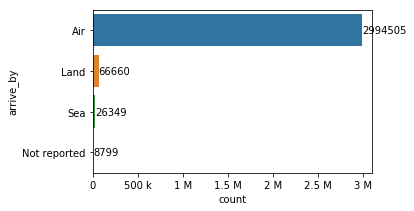

In [10]:
h.plot_top(i94data, 'arrive_by')

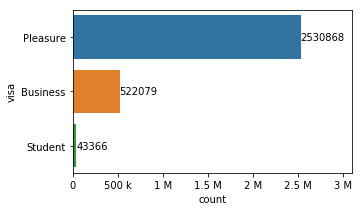

In [11]:
h.plot_top(i94data, 'visa')

#### 1.1.3 Check missing and duplicate IDs

In [12]:
i94data.groupBy('i94_id').count().where('count > 1').show(10)

+------+-----+
|i94_id|count|
+------+-----+
+------+-----+



In [13]:
i94data.where('i94_id is null').count()

0

There are no missing or duplicate rows by `i94_id`

#### 1.1.4 Check date boundaries

In [14]:
i94data.select(f.min('arrive_date'), f.max('arrive_date')).show()

+----------------+----------------+
|min(arrive_date)|max(arrive_date)|
+----------------+----------------+
|      2016-04-01|      2016-04-30|
+----------------+----------------+



In [15]:
i94data.select(f.min('depart_date'), f.max('depart_date')).show()

+----------------+----------------+
|min(depart_date)|max(depart_date)|
+----------------+----------------+
|      2001-07-20|      2084-05-16|
+----------------+----------------+



This is weird, do we have records with `depart_date > current_date()`?

In [16]:
i94data.select('arrive_date', 'depart_date').where(i94data.depart_date > f.current_date()).show()

+-----------+-----------+
|arrive_date|depart_date|
+-----------+-----------+
| 2016-04-05| 2084-05-16|
| 2016-04-25| 2069-05-03|
+-----------+-----------+



Anyway, this can be addressed on ETL.

In [17]:
i94data.select('i94_id',
               'arrive_date',
               'arrive_port',
               'arrive_by',
               'arrive_to_state',
               'pers_country_birth',
               'pers_country_resid',
               'visa',
               'visa_type').where('arrive_to_state = "MO"').show(10)

+-------+-----------+-----------+---------+---------------+------------------+------------------+--------+---------+
| i94_id|arrive_date|arrive_port|arrive_by|arrive_to_state|pers_country_birth|pers_country_resid|    visa|visa_type|
+-------+-----------+-----------+---------+---------------+------------------+------------------+--------+---------+
|5748993| 2016-04-30|        CHI|      Air|             MO|               250|               250|Business|       B1|
|5749006| 2016-04-30|        CHI|      Air|             MO|               250|               250|Pleasure|       B2|
|5749733| 2016-04-30|        MIA|      Sea|             MO|               251|               251|Pleasure|       B2|
|5749734| 2016-04-30|        MIA|      Sea|             MO|               251|               251|Pleasure|       B2|
|5749735| 2016-04-30|        MIA|      Sea|             MO|               251|               251|Pleasure|       B2|
|5749736| 2016-04-30|        MIA|      Sea|             MO|     

### 1.2 Countries
Having integer ids for countries is not sufficient, so I made `I94Countries.csv` based on labels descriptions.

In [20]:
countries = spark.read.csv('dimension_data/I94Countries.csv',
                           sep = ';',
                           inferSchema = True, header = True)
countries.show(3)

+---+--------------------+
| id|                name|
+---+--------------------+
|582|'MEXICO Air Sea, ...|
|236|       'AFGHANISTAN'|
|101|           'ALBANIA'|
+---+--------------------+
only showing top 3 rows



Strip quotes from names

In [21]:
countries = countries.withColumn('name', h.udf_strip_quotes('name'))
countries.show(3)

+---+--------------------+
| id|                name|
+---+--------------------+
|582|MEXICO Air Sea, a...|
|236|         AFGHANISTAN|
|101|             ALBANIA|
+---+--------------------+
only showing top 3 rows



Do we have any missing country ids in the immigration data?

In [22]:
i94data.join(countries,
              (i94data.pers_country_resid == countries.id),
              how = 'left_anti') \
        .groupBy('pers_country_resid') \
        .count().sort(f.desc('count')).show()

+------------------+-----+
|pers_country_resid|count|
+------------------+-----+
+------------------+-----+



None for the country of residence.

In [23]:
ne_countries = i94data \
    .join(countries,
          (i94data.pers_country_birth == countries.id),
          how = 'left_anti') \
    .groupBy('pers_country_birth') \
    .count().sort(f.desc('count'))
ne_countries.show(10)

+------------------+------+
|pers_country_birth| count|
+------------------+------+
|               148|157806|
|               254|137735|
|               252| 41132|
|               746| 22668|
|               133| 17055|
|               180|  4115|
|               734|  2721|
|               718|   866|
|               756|   846|
|               714|   390|
+------------------+------+
only showing top 10 rows



Plenty for the country of birth. Since these ids do not appear as the country of residence I suspect they stand for nonexistent countries like the Soviet Union and Yugoslavia. A check against [ISO-3166-1](https://en.wikipedia.org/wiki/ISO_3166-1) shows that I94 country IDs are not even the ISO numeric country codes. What I can do is to add these ids to `countries` as e.g. 'Nonexistent 148'.

In [24]:
print(f'{countries.count()} countries original, append with')
print(f'{ne_countries.count()} countries nonexistent:')

countries = countries \
    .union(ne_countries \
           .withColumnRenamed('pers_country_birth', 'id') \
           .withColumn('name', h.udf_name_ne('id')) \
           .drop('count'))

print(f'{countries.count()} countries total.')

289 countries original, append with
30 countries nonexistent:
319 countries total.


In [25]:
countries.where('id in (101, 236, 133, 180)').show()

+---+---------------+
| id|           name|
+---+---------------+
|236|    AFGHANISTAN|
|101|        ALBANIA|
|133|Nonexistent 133|
|180|Nonexistent 180|
+---+---------------+



In [26]:
i94data.join(countries,
              (i94data.pers_country_birth == countries.id),
              how = 'left_anti') \
        .groupBy('pers_country_birth') \
        .count().sort(f.desc('count')).show()

+------------------+-----+
|pers_country_birth|count|
+------------------+-----+
+------------------+-----+



No more missing ids for the country of birth.

### 1.3 Cities Demographics Data 
This data comes [from OpenSoft](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/).

In [27]:
citydem = spark.read.csv('dimension_data/us-cities-demographics.csv',
                         sep = ';',
                         inferSchema = True, header = True)

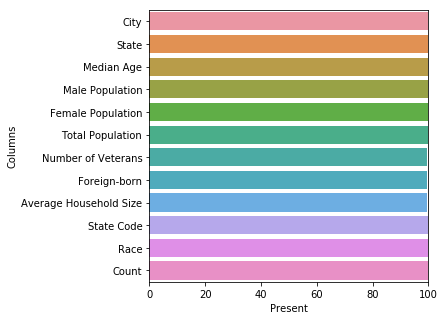

In [28]:
h.plot_present(citydem)

Note that cities demographics has composite primary key (`City`, `State`, `State Code`, `Race`)

In [29]:
citydem.groupBy('City', 'State', 'State Code', 'Race').count().where('count > 1').show(10)

+----+-----+----------+----+-----+
|City|State|State Code|Race|count|
+----+-----+----------+----+-----+
+----+-----+----------+----+-----+



The combination (`City`, `State`, `State Code`) repeats as many times as many `Race` values are registered per city, with `Count` showing the population associated with the race, while other numbers like `Median Age`, `Male Population`, `Female Population`, `Total Population`, `Foreign-born` are given per city, not per city in combination with race.

In [30]:
citydem.select('City', 'State', 'State Code', 'Race', 'Count', 'Median Age',
               'Male Population', 'Female Population', 'Total Population') \
       .where('City = "Springfield" and State = "Missouri"').show()

+-----------+--------+----------+--------------------+------+----------+---------------+-----------------+----------------+
|       City|   State|State Code|                Race| Count|Median Age|Male Population|Female Population|Total Population|
+-----------+--------+----------+--------------------+------+----------+---------------+-----------------+----------------+
|Springfield|Missouri|        MO|               Asian|  5725|      34.1|          81057|            85741|          166798|
|Springfield|Missouri|        MO|Black or African-...| 10026|      34.1|          81057|            85741|          166798|
|Springfield|Missouri|        MO|               White|151686|      34.1|          81057|            85741|          166798|
|Springfield|Missouri|        MO|  Hispanic or Latino|  7100|      34.1|          81057|            85741|          166798|
|Springfield|Missouri|        MO|American Indian a...|  2777|      34.1|          81057|            85741|          166798|
+-------

In the target DWH model, demographics will be normalized by splitting races and race counts into a separate table.

Check for missing values:

In [31]:
for c in ['City', 'State', 'State Code', 'Race']:
    cnt = citydem.where(f.col(c).isNull()).count()
    print(f'Empty {c}: {cnt}')

Empty City: 0
Empty State: 0
Empty State Code: 0
Empty Race: 0


Let's rename columns to remove spaces:

In [32]:
citydem = citydem \
    .withColumnRenamed('City',                   'city') \
    .withColumnRenamed('State',                  'state') \
    .withColumnRenamed('Median Age',             'age_median') \
    .withColumnRenamed('Male Population',        'pop_male') \
    .withColumnRenamed('Female Population',      'pop_female') \
    .withColumnRenamed('Total Population',       'pop_total') \
    .withColumnRenamed('Number of Veterans',     'pop_veteran') \
    .withColumnRenamed('Foreign-born',           'pop_foreign_born') \
    .withColumnRenamed('Average Household Size', 'avg_household_size') \
    .withColumnRenamed('State Code',             'state_code') \
    .withColumnRenamed('Race',                   'race') \
    .withColumnRenamed('Count',                  'race_count')

### 1.4 Airport Codes 
This is a simple table of airport codes and corresponding cities. It comes from [here](https://datahub.io/core/airport-codes#data). We can immediately narrow the table to only the US airports for match with the immigration data.

In [33]:
airports = spark.read.csv('dimension_data/airport-codes.csv',
                          sep = ',',
                          inferSchema = True, header = True)            

In [34]:
airports = airports.where('iso_country = "US"')
airport_cnt = airports.count()
print(f'{airport_cnt} total US airports.')

22757 total US airports.


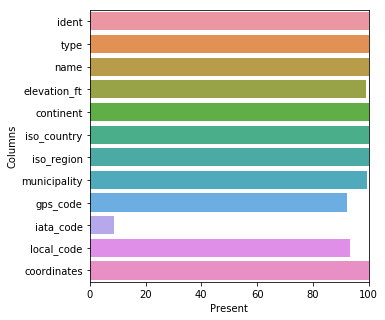

In [35]:
h.plot_present(airports)

Drop `iata_code` as mostly empty, `continent`, `iso_country` since we have limited the table to US records.

In [36]:
airports = airports.drop('continent', 'iso_country', 'iata_code')

Check for missing values

In [37]:
airports.where('ident is null').count()

0

Check for duplicates

In [38]:
airports.groupBy('ident').count().where('count > 1').show(10)

+-----+-----+
|ident|count|
+-----+-----+
+-----+-----+



Renaming and value conversions

In [39]:
airports = airports \
    .withColumnRenamed('ident',        'id') \
    .withColumn(       'state_code',   h.udf_state('iso_region')) \
    .withColumnRenamed('municipality', 'city') \
    .withColumn(       'lat',          h.udf_lat('coordinates')) \
    .withColumn(       'long',         h.udf_long('coordinates')) \
    .drop('coordinates', 'iso_region')
airports.where('state_code = "MO"').show(10)

+----+-------------+--------------------+------------+----------------+--------+----------+----------+---------+---------+
|  id|         type|                name|elevation_ft|            city|gps_code|local_code|state_code|      lat|     long|
+----+-------------+--------------------+------------+----------------+--------+----------+----------+---------+---------+
|00MO|small_airport|Cooper Flying Ser...|         970|            Alba|    00MO|      00MO|        MO| -94.4124|  37.2028|
|01MO|     heliport|Highway Patrol Tr...|         615|Town and Country|    01MO|      01MO|        MO| -90.4843|  38.6417|
|02MO|small_airport|        Troy Airpark|         650|            Troy|    02MO|      02MO|        MO| -91.0335|    39.05|
|02MU|       closed| Timber Line Airpark|        1550|       Cassville|    null|      null|        MO|-93.79742|36.654232|
|03MO|       closed|   Cahoochie Airport|        1010|          Urbana|    null|      null|        MO| -93.1316|  37.8845|
|03MU|small_airp

#### 1.4.1 Match Airport to Arrival Port
Which of the airport codes best matches to `i94_stage.arrive_port`?

Limiting the immigration data to arrivals by air, we have this many unique arrival ports:

In [40]:
i94data.where('arrive_by = "Air"') \
       .select('arrive_port') \
       .distinct().count()

181

With match by the airport id, we have this many misses:

In [41]:
i94data.where('arrive_by = "Air"') \
       .select('arrive_port') \
       .join(airports,
             (i94data.arrive_port == airports.id),
             how = 'left_anti') \
       .distinct().count()

174

No match for the airport id. What about the GPS code?

In [42]:
i94data.where('arrive_by = "Air"') \
       .select('arrive_port') \
       .join(airports,
             (i94data.arrive_port == airports.gps_code),
             how = 'left_anti') \
       .distinct().count()

179

No match either. What about the local code?

In [43]:
i94data.where('arrive_by = "Air"') \
       .select('arrive_port') \
       .join(airports,
             (i94data.arrive_port == airports.local_code),
             how = 'left_anti') \
       .distinct().count()

72

Is `local_code` unique?

In [44]:
airports.groupBy('local_code').count().where('count > 1').show(10)

+----------+-----+
|local_code|count|
+----------+-----+
|      LL69|    2|
|      1TS9|    2|
|      3MI4|    2|
|      K0Q5|    2|
|       FHB|    2|
|      XS29|    2|
|       6X8|    2|
|      TA29|    2|
|       L11|    2|
|      29NC|    2|
+----------+-----+
only showing top 10 rows



Let's take a closer look at some duplicating local codes:

In [45]:
airports.select('id', 'city', 'state_code', 'name', 'local_code') \
        .where('local_code in ("LL69", "1TS9", "FHB", "6X8", "L11")') \
        .sort('local_code').show(10, False)

+-------+----------------+----------+----------------------------------+----------+
|id     |city            |state_code|name                              |local_code|
+-------+----------------+----------+----------------------------------+----------+
|1TS9   |Celina          |TX        |Four Winds Airport                |1TS9      |
|US-0389|Del Rio         |TX        |Indianhead Ranch Airport          |1TS9      |
|6XS8   |Sanger          |TX        |Vultures Row Airport              |6X8       |
|US-0311|Sangar          |TX        |Vultures Row                      |6X8       |
|FHB    |Fernandina Beach|FL        |Fernandina Beach Muni Airport     |FHB       |
|K55J   |Fernandina Beach|FL        |Fernandina Beach Municipal Airport|FHB       |
|US-0308|Avalon          |CA        |Pebbly Beach Seaplane Base Helipad|L11       |
|L11    |Avalon          |CA        |Pebbly Beach Seaplane Base        |L11       |
|LL69   |Ridott          |IL        |Cambier Airport                   |LL69

Airports having the local code:

In [46]:
airports_l = airports.where('local_code is not null') \
                     .select('id', 'city', 'state_code') \
                     .distinct().count()

print(f'{airports_l} out of {airport_cnt} airports ({(100 * airports_l / airport_cnt):.2f}%) have the local code.')

21236 out of 22757 airports (93.32%) have the local code.


Airports with duplicating local codes:

In [47]:
airports_d = airports.where('local_code is not null') \
                     .groupBy('local_code') \
                     .count().where('count > 1') \
                     .agg(f.sum('count')).first()[0]
print(f'{airports_d} out of {airports_l} airports ({(100 * airports_d / airports_l):.2f}%) have duplicating local code.')

132 out of 21236 airports (0.62%) have duplicating local code.


The duplicating local code problem is not of a big scale, however it is complex: we have some clearly duplicating records, but as well some airports with the same local code. I cannot think of a code to fix it so far.

Local code is a close match to arrival port by air, still the data quality is poor:
1. Local codes missing for some airports
1. Immigration data using three letter city codes instead of airport codes
1. Airports with duplicating records and duplicating local codes

#### 1.4.2 Match Airport to City
Let's check how airports connect with cities. How many airports do not match to cities in cities dempgraphics?

In [48]:
airports_c = airports.where('local_code is not null') \
                     .select('id', 'city', 'state_code')
cities = citydem.select('city', 'state_code').distinct()

no_match_cnt = airports_c \
    .join(cities,
          (airports_c.city == cities.city) &
          (airports_c.state_code == cities.state_code),
          how = 'left_anti') \
    .count()

print(f'{no_match_cnt} out of {airport_cnt} airports ({(100 * no_match_cnt / airport_cnt):.2f}%) don\'t match cities.')

18538 out of 22757 airports (81.46%) don't match cities.


Connection between cities and airports does not have much value.

### 1.5 World Temperature Data
This dataset came from [Kaggle](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data). Since the immigration data is only available at the state level of detail, we'll use temperatures by state also here.

In [49]:
wtd = spark.read.csv('dimension_data/WTD-By-State.csv',
                     sep = ',',
                     inferSchema = True, header = True)
wtd.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- State: string (nullable = true)
 |-- Country: string (nullable = true)



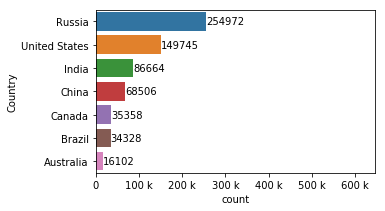

In [50]:
h.plot_top(wtd, 'Country')

In [51]:
wtd = wtd.where('Country = "United States"').drop('Country')

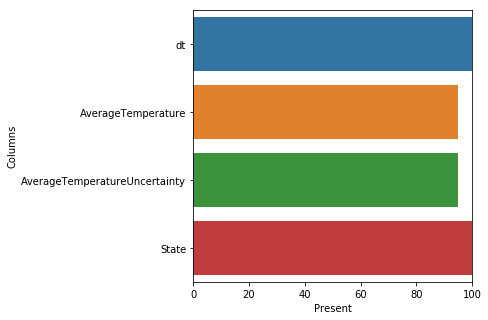

In [52]:
h.plot_present(wtd)

Rename columns

In [53]:
wtd = wtd \
    .withColumn(       'date',                          wtd.dt.cast(DateType())) \
    .withColumnRenamed('AverageTemperature',            'temp_avg') \
    .withColumnRenamed('AverageTemperatureUncertainty', 'temp_unc') \
    .withColumnRenamed('State',                         'state')

Let's check whether the temperature data covers the time period of our immigration data.

In [54]:
i94data.select(f.min('arrive_date'), f.max('arrive_date')).show()

+----------------+----------------+
|min(arrive_date)|max(arrive_date)|
+----------------+----------------+
|      2016-04-01|      2016-04-30|
+----------------+----------------+



In [55]:
wtd.select(f.min('date'), f.max('date')).show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|1743-11-01|2013-09-01|
+----------+----------+



Surprisingly for 2021, the Kaggle dataset ends in 2013. I don't see a lot of value in using the temperature data when in does not match in time with our fact data.

## 2 Define the Data Model
### 2.1 Conceptual Data Model
#### 2.1.1 Fact: Immigration

In [56]:
i94data.printSchema()

root
 |-- i94_id: integer (nullable = true)
 |-- arrive_year: integer (nullable = true)
 |-- arrive_month: integer (nullable = true)
 |-- pers_country_birth: integer (nullable = true)
 |-- pers_country_resid: integer (nullable = true)
 |-- arrive_port: string (nullable = true)
 |-- arrive_date: date (nullable = true)
 |-- arrive_by: string (nullable = true)
 |-- arrive_to_state: string (nullable = true)
 |-- depart_date: date (nullable = true)
 |-- pers_age: integer (nullable = true)
 |-- visa: string (nullable = true)
 |-- visa_issued: string (nullable = true)
 |-- arrive_flag: string (nullable = true)
 |-- depart_flag: string (nullable = true)
 |-- match_flag: string (nullable = true)
 |-- pers_birth_year: integer (nullable = true)
 |-- allow_stay_until: string (nullable = true)
 |-- pers_gender: string (nullable = true)
 |-- arrive_airline: string (nullable = true)
 |-- admission_number: double (nullable = true)
 |-- arrive_flight: string (nullable = true)
 |-- visa_type: string (nu

The fact table is already in a good shape. We can separate a `date` dimension based on `arrive_date` *and* `depart_date` and keep columns `arrive_year` and `arrive_month` for partitioning.

#### 2.1.2 Dimension: Date

In [57]:
date = i94data \
    .selectExpr('arrive_date as date').distinct() \
    .union(i94data.selectExpr('depart_date as date').distinct()) \
    .distinct() \
    .withColumn('year',    f.year('date')) \
    .withColumn('month',   f.month('date')) \
    .withColumn('week',    f.weekofyear('date')) \
    .withColumn('day',     f.dayofmonth('date')) \
    .withColumn('weekday', f.dayofweek('date'))

date.count()

236

Check duplicates:

In [58]:
date.groupBy('date').count().where('count > 1').show(10)

+----+-----+
|date|count|
+----+-----+
+----+-----+



Check boundaries, mind the depart date is included, see section 1.1.4

In [59]:
date.select(f.min('date'), f.max('date')).show()

+----------+----------+
| min(date)| max(date)|
+----------+----------+
|2001-07-20|2084-05-16|
+----------+----------+



#### 2.1.3 Dimension: Countries

In [60]:
countries.printSchema()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)



Countries dimension is complete. The fact table links to it with `pers_country_birth` and `pers_country_resid`.

#### 2.1.4 Dimension: States

In [61]:
citydem.printSchema()

root
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- age_median: double (nullable = true)
 |-- pop_male: integer (nullable = true)
 |-- pop_female: integer (nullable = true)
 |-- pop_total: integer (nullable = true)
 |-- pop_veteran: integer (nullable = true)
 |-- pop_foreign_born: integer (nullable = true)
 |-- avg_household_size: double (nullable = true)
 |-- state_code: string (nullable = true)
 |-- race: string (nullable = true)
 |-- race_count: integer (nullable = true)



In the fact table, the arrival destination information is limited to state, see `arrive_to_state`. Demographics on the state level rather than the city level would be sufficient in this case. First, let's aggregate based on state without race:

In [62]:
states = citydem \
    .groupBy('state', 'state_code') \
    .agg(f.sum('pop_male').alias('pop_male'),
         f.sum('pop_female').alias('pop_female'),
         f.sum('pop_total').alias('pop_total'),
         f.sum('pop_veteran').alias('pop_veteran'),
         f.sum('pop_foreign_born').alias('pop_foreign_born'))

states.where('state = "Missouri"').show()

+--------+----------+--------+----------+---------+-----------+----------------+
|   state|state_code|pop_male|pop_female|pop_total|pop_veteran|pop_foreign_born|
+--------+----------+--------+----------+---------+-----------+----------------+
|Missouri|        MO| 3666310|   3929660|  7595970|     457265|          495475|
+--------+----------+--------+----------+---------+-----------+----------------+



Note that the age median and the average household size cannot be accurately aggregated from cities:
* Median can be approximated as median of the city medians, still inaccurate;
* For the state average household size we don't know the quantity of households.

We can also have race counts aggregated per state:

#### 2.1.5 Dimension: State Race Counts
We have the state name also here to skip join with `states` when the race counts are used.

In [63]:
state_race_counts = citydem \
    .groupBy('state', 'state_code', 'race') \
    .agg(f.sum('race_count').alias('race_count'))

state_race_counts.where('state = "Missouri"').show()

+--------+----------+--------------------+----------+
|   state|state_code|                race|race_count|
+--------+----------+--------------------+----------+
|Missouri|        MO|American Indian a...|     18550|
|Missouri|        MO|               Asian|     55349|
|Missouri|        MO|Black or African-...|    360720|
|Missouri|        MO|               White|   1085809|
|Missouri|        MO|  Hispanic or Latino|     99147|
+--------+----------+--------------------+----------+



Note that the race counts don't sum up to the total population on the city level already, so we don't expect this per state either.

#### 2.1.6 Dimension: Airports

In [64]:
airports.printSchema()

root
 |-- id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)



Airports dimension is complete. The `local_code` links to the fact table attribute `arrive_port`, see section 1.4.1 above.

### 2.2 Further Steps
* Data model diagram, see `README.md`
* Data dictionary, see `data_dictionary.md`
* Notebook `etl_test.ipynb` maps and implements the ETL pipeline